# Style Transfer Algorithm Notebook
Adapted from pytorch Neural Style Transfer tutorial:

https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [2]:
USING_GPU = True
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    USING_GPU = False

In [3]:
# desired size of the output image
imsize = 256

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

def image_loader(image_name: str|list) -> torch.Tensor:
    """
    load image or list of images from path and return as tensor
    :param image_name: path to image or list of paths to images
    :return: 4D tensor of images
    """
    if isinstance(image_name, list):
        images = []
        for name in image_name:
            image = Image.open(name)
            image = loader(image).unsqueeze(0)
            images.append(image)
        return torch.cat(images, dim=0).to(device, torch.float)
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Example images
style_img = image_loader("./data/examples/picasso.jpg")
content_img = image_loader("./data/examples/dancing.jpg")

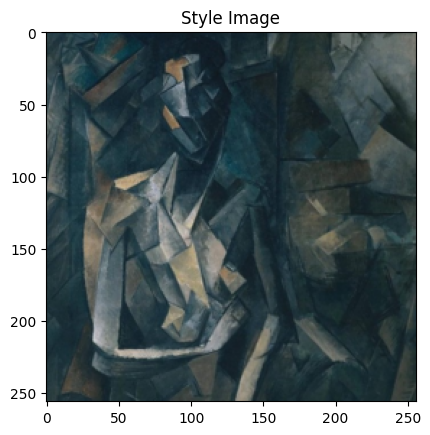

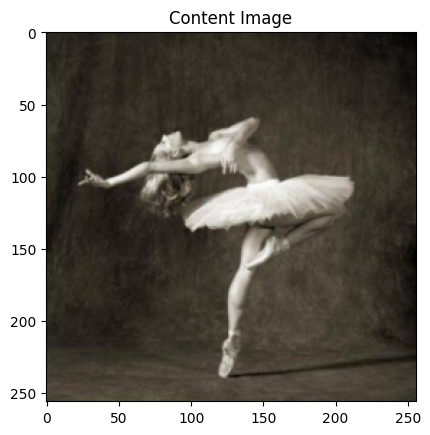

In [4]:
image_unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = image_unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [5]:
class ContentLoss(nn.Module):
    """
    Calculate the Content loss of images against a single fixed target image
    """
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # Target image is not a parameter of the model, so we don't need to backpropagate through it
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size() 
    # a = batch size
    # b = number of feature maps (channels of image)
    # (c,d) = dimensions of a f. map (N=c*d) (N = number of pixels in feature map)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):
    """
    Computes the style loss of a given image against a target style image
    Style loss is calculated as the mean squared error between the Gram matrices of the target and the input image
    """
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        # Store the gram matrix of the target image
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [8]:
# Using pretrained VGG19 model
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

In [9]:
# VGG normalization parameters
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    """
    Module to normalize the input image so that the mean is 0 and the standard deviation is 1
    """
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # Mean and std are 1D tensors of size 3, calculated along the channels of the image
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
# VGG module specific operatiosn
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    """
    Function to extract the style and content losses from a sequential CNN model
    :param cnn: Sequential CNN model
    :param normalization_mean: mean of the normalization
    :param normalization_std: standard deviation of the normalization
    :param style_img: style image
    :param content_img: content image
    :param content_layers: list of content layers
    :param style_layers: list of style layers
    :return: model: Sequential CNN model with added style and content losses,
        style_losses: list of style losses detected from the model,
        content_losses: list of content losses detected from the model
    """
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses, since we don't need them
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    # i+1 is the index of the first layer after the last content/style loss
    model = model[:(i + 1)]

    return model, style_losses, content_losses

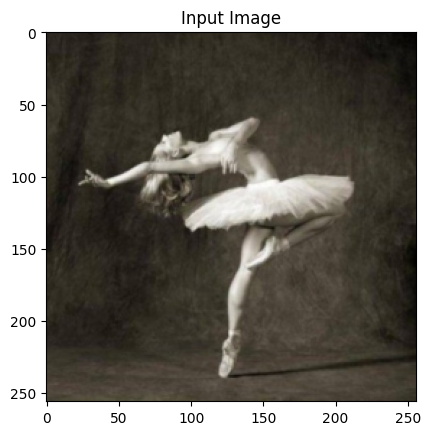

In [11]:
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """
    Runs style transfer from a Sequential pre-trained CNN model
    :param cnn: Sequential CNN model
    :param normalization_mean: mean used to normalize the input image
    :param normalization_std: standard deviation used to normalize the input image
    :param content_img: content image
    :param style_img: style image
    :param input_img: input image
    :param num_steps: number of steps to run the optimization
    :param style_weight: weight of the style loss
    :param content_weight: weight of the content loss
    """
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    print('Model built successfully')

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            """
            Performs a single optimization step
            """
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        # Output image should be clamped between 0 and 1
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..


/var/folders/_5/tswfwkss0k1c6sfrrhpfkpkr0000gn/T/ipykernel_30058/112230516.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/_5/tswfwkss0k1c6sfrrhpfkpkr0000gn/T/ipykernel_30058/112230516.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Model built successfully
Optimizing..
run [50]:
Style Loss : 8.989247 Content Loss: 6.590780

run [100]:
Style Loss : 2.324943 Content Loss: 4.855687

run [150]:
Style Loss : 1.236914 Content Loss: 4.098633

run [200]:
Style Loss : 0.902698 Content Loss: 3.723974

run [250]:
Style Loss : 0.701193 Content Loss: 3.531228

run [300]:
Style Loss : 0.586739 Content Loss: 3.407776



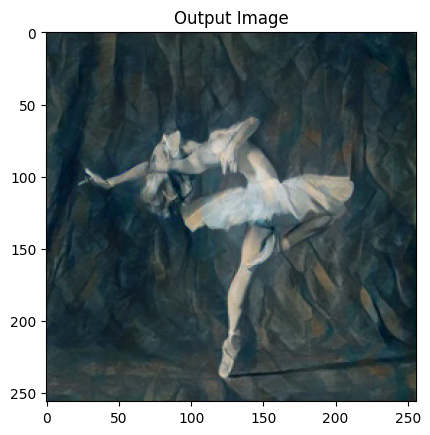

In [14]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()